In [1]:
import torch 
import gpytorch
from matplotlib import pyplot as plt
import sys
import os
sys.path.append(os.path.abspath('../..'))

from pv_plot.plotting import plot_gp, plot_gp_ax, plot_train_test_split
from data import PVDataGenerator, PVDataLoader
from data.utils import *
from models import ApproximateGPBaseModel
from likelihoods.beta import BetaLikelihood_MeanParametrization
from kernels import Kernel

In [2]:
# data parameters
DAY_INIT = 6
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 300
RADIUS = 0.35
COORDS = (55, -1.5)
POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

==> Loading data
==> Loaded data in: 0 m : 2 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



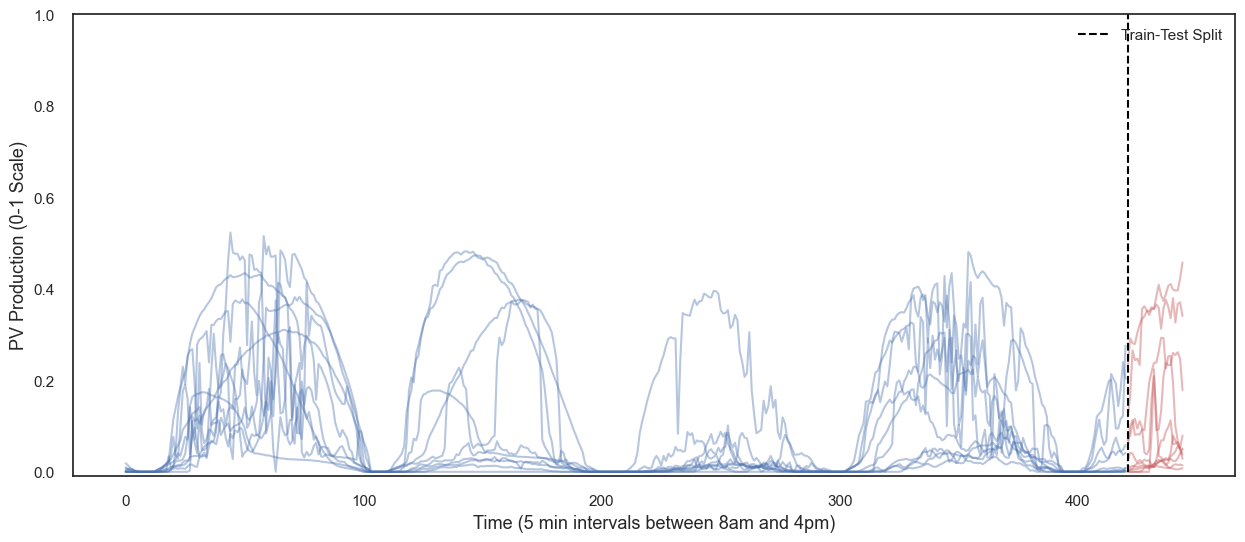

In [3]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=POLY_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='poly',
                    drop_nan=True)
# randomly select 10 systems
X, y = generator.get_time_series()
idx = np.random.choice(y.size(-1) - 1, size=10, replace=False)
y = y[:, idx]

x_train, y_train, x_test, y_test = train_test_split(X, y, hour=13)

plt.rcParams['font.family'] = 'Arial'
plot_train_test_split(y_train, y_test)


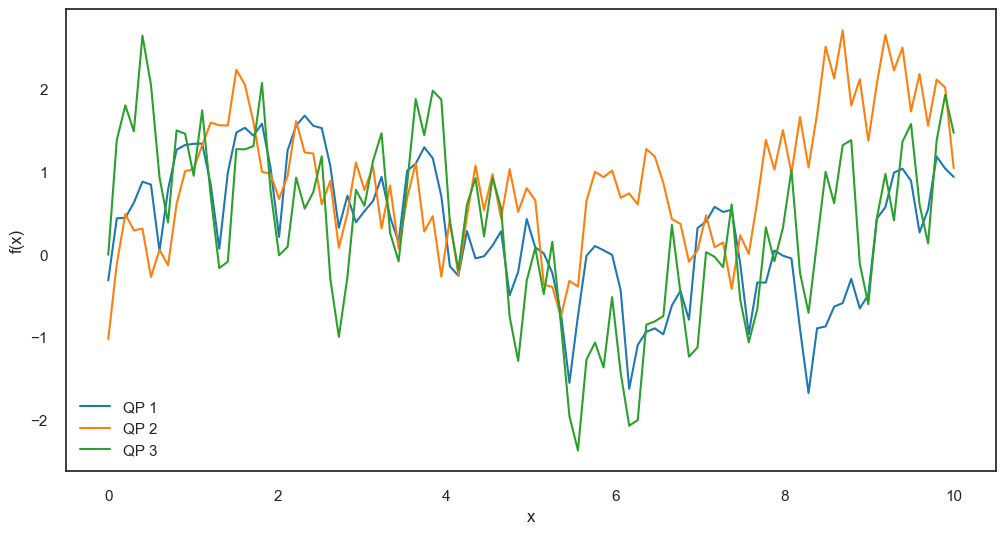

In [24]:
from gpytorch.means import ZeroMean, ConstantMean
from gpytorch.constraints import Interval, Positive

mean = ZeroMean()

kernel = Kernel()
matern_base = kernel.get_matern(lengthscale_constraint=Positive(),
                                outputscale_constraint=Positive())
matern_quasi = kernel.get_matern(lengthscale_constraint=Positive(initial_value=1000),
                                 outputscale_constraint=Positive())
periodic1 = kernel.get_periodic(lengthscale_constraint= Positive(),
                                outputscale_constraint=Positive())
periodic2 = kernel.get_periodic(lengthscale_constraint= Positive(initial_value=1),
                                outputscale_constraint=Positive()
                                )

kernel = kernel.get_quasi_periodic(matern_base=matern_base, 
                                    matern_quasi=matern_quasi,
                                    periodic1=periodic1)

x = torch.linspace(0, 10, 100)
dist = gpytorch.distributions.MultivariateNormal(mean(x), kernel(x))
samples = dist.rsample(torch.Size([3]))
cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in range(3)]
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(x, samples[i].detach().numpy(), label=f"QP {i+1}", color=colors[i])

plt.xlabel(r"x")
plt.ylabel(r"f(x)")
plt.legend()
plt.show()

In [44]:
# create sinusoidal data
x = torch.linspace(0, 20, 400)
y = torch.sin(x)*0.2 + 0.5 + torch.randn_like(x)*0.04
n_tr = int(len(x)*0.8)
x_train, y_train = x[:n_tr], y[:n_tr]
x_test, y_test = x[n_tr:], y[n_tr:]

Iter 10/100 - Loss: -0.582
Iter 20/100 - Loss: -0.705
Iter 30/100 - Loss: -0.769
Iter 40/100 - Loss: -0.770
Iter 50/100 - Loss: -0.771
Iter 60/100 - Loss: -0.771
Iter 70/100 - Loss: -0.771
Iter 80/100 - Loss: -0.771
Iter 90/100 - Loss: -0.771
Iter 100/100 - Loss: -0.771
Iter 10/100 - Loss: -1.131
Iter 20/100 - Loss: -1.118
Iter 30/100 - Loss: -1.184
Iter 40/100 - Loss: -1.220
Iter 50/100 - Loss: -1.225
Iter 60/100 - Loss: -1.234
Iter 70/100 - Loss: -1.240
Iter 80/100 - Loss: -1.245
Iter 90/100 - Loss: -1.250
Iter 100/100 - Loss: -1.254


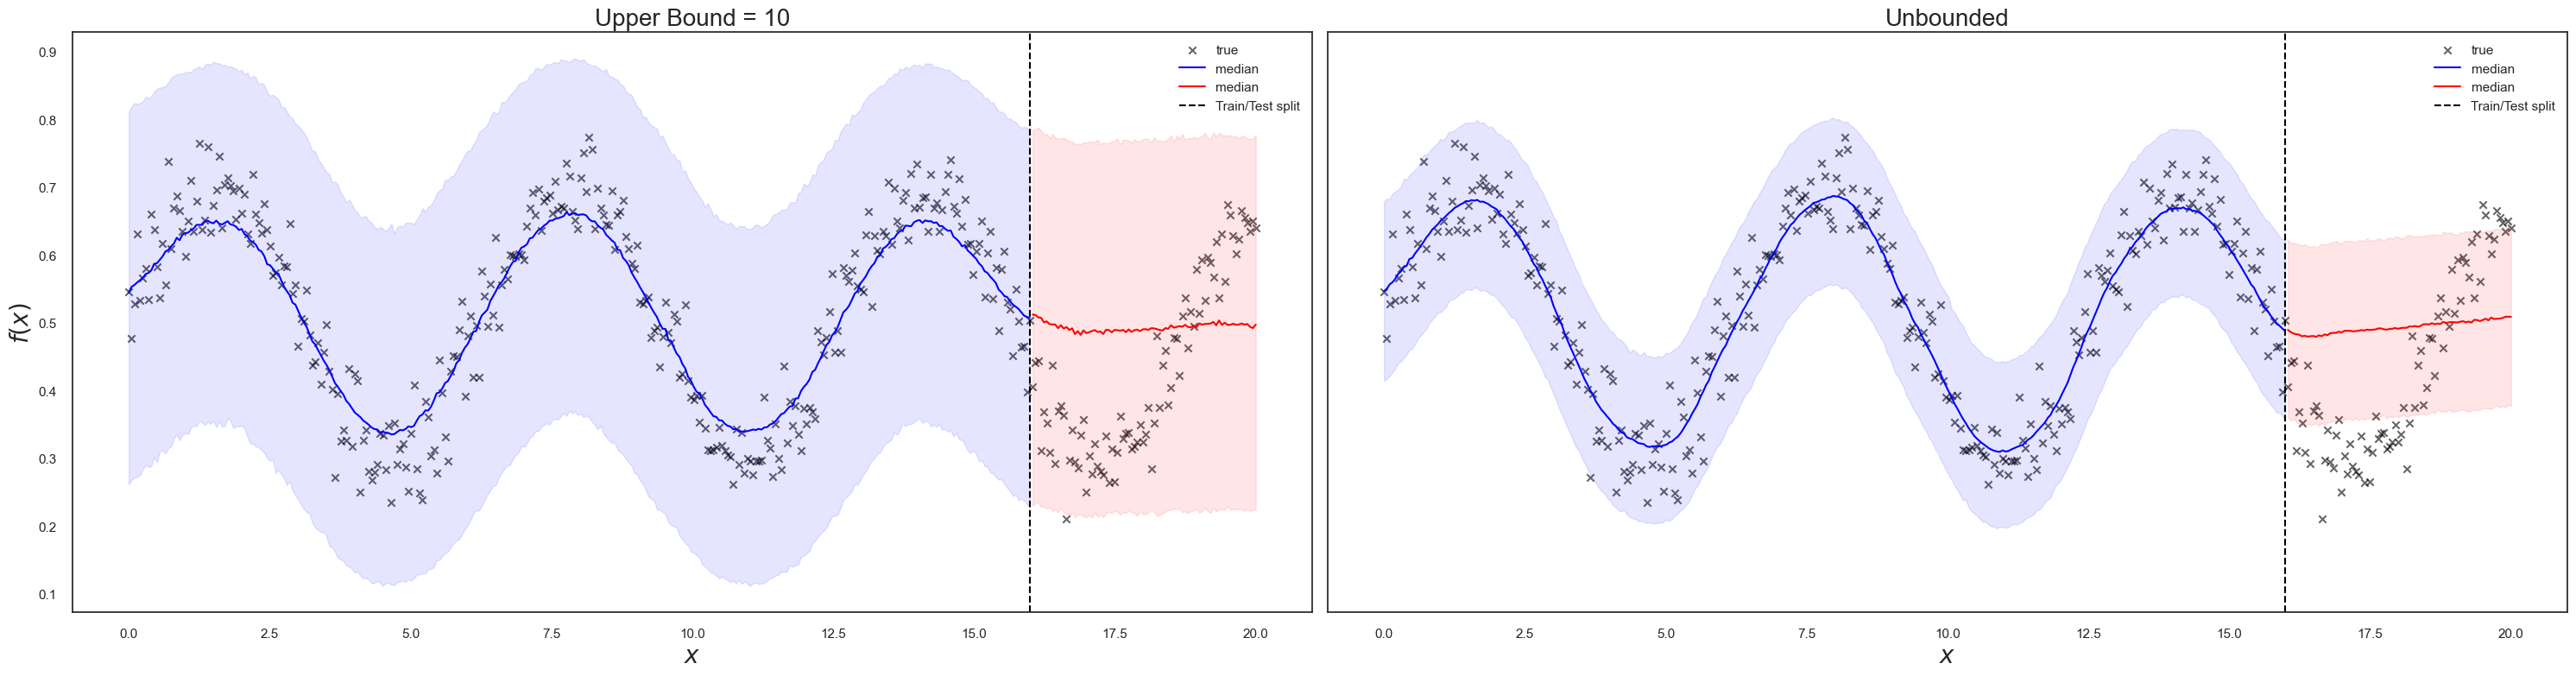

In [46]:
jitter = 1e-6

config = {  'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_train.size(0),
            'jitter_val': jitter
            }
inputs ={
    'X' : x_train,
    'y' : y_train,
    'config': config,
    'jitter': jitter,
    'mean_module': mean,
    'covar_module': kernel,
    'learn_inducing_locations': False
}

n_loops = y_train.size(-1)
#f ig, axes = plt.subplots(y_train.size(-1) // 2, 2, figsize=(40, 8*n_loops // 2))
# axes = axes.flatten()
fig, ax = plt.subplots(1, 2, figsize=(30, 8), sharey=True)
ax = ax.flatten()
n_loops = 1
for idx, upper_bnd in enumerate([10, 5000]):
    inputs['likelihood'] = BetaLikelihood_MeanParametrization(scale=5 if upper_bnd == 10 else 40, 
                                                              scale_upper_bnd=upper_bnd)
    model_beta = ApproximateGPBaseModel(**inputs)
    model_beta.fit(n_iter=100, lr=0.2,  verbose=True)
    
    ax[idx].scatter(x, y, label='true', color='black', marker='x', alpha=0.6)

    median, lower, upper = model_beta.predict(x_train, pred_type='median')
    ax[idx].plot(x_train, median, label='median', color='blue')
    ax[idx].fill_between(x_train, lower, upper, alpha=0.1, color='blue')

    median, lower, upper = model_beta.predict(x_test, pred_type='median')
    ax[idx].plot(x_test, median, label='median', color='red')
    ax[idx].fill_between(x_test, lower, upper, alpha=0.1, color='red')

    ax[idx].axvline(x=x_train.max(), color='black', linestyle='--', label='Train/Test split')

    if idx == 0:
        ax[idx].set_title(f'Upper Bound = {upper_bnd}', fontsize=20)
    else:
        ax[idx].set_title(f'Unbounded', fontsize=20)
    ax[idx].set_xlabel(r'$x$', fontsize=20)
    if idx == 0:
        ax[idx].set_ylabel(r'$f(x)$', fontsize=20)
  
    ax[idx].legend()

plt.tight_layout()
plt.show()


## Weather Data

In [2]:
# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 21
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 // MINUTE_INTERVAL
N_DAYS_FOLD = 8
N_SYSTEMS = 10
CIRCLE_COORDS = (53.5, -3)
RADIUS = 0.4
interval = int(DAILY_DATA_POINTS * N_DAYS_FOLD)

In [3]:
from data import SystemLoader, PVWeatherGenerator
generator = PVWeatherGenerator(
    coords=CIRCLE_COORDS,
    radius=RADIUS,
    day_init=DAY_INIT,
    n_systems=N_SYSTEMS,
    n_days=N_DAYS,
    minute_interval=MINUTE_INTERVAL,
)
loader = SystemLoader(generator.df, train_interval=interval)

==> Loading data
==> Loaded data in: 0 m : 23 sec



In [4]:
jitter = 1e-4
gp_config = {
        'type' : 'stochastic', # SVI
        'name' : 'cholesky', # type of posterior covariance approximation
        'jitter' : jitter, # jitter for numerical stability
    }

Iter 20/200 - Loss: 3.087
Iter 40/200 - Loss: -0.964
Iter 60/200 - Loss: -2.120
Iter 80/200 - Loss: -2.602
Iter 100/200 - Loss: -2.875
Iter 120/200 - Loss: -2.958
Iter 140/200 - Loss: -3.075
Iter 160/200 - Loss: -3.129
Iter 180/200 - Loss: -3.094
Iter 200/200 - Loss: -3.182
Iter 20/200 - Loss: 11.938
Iter 40/200 - Loss: -0.026
Iter 60/200 - Loss: -1.296
Iter 80/200 - Loss: -1.759
Iter 100/200 - Loss: -1.978
Iter 120/200 - Loss: -2.137
Iter 140/200 - Loss: -2.259
Iter 160/200 - Loss: -2.358
Iter 180/200 - Loss: -2.441
Iter 200/200 - Loss: -2.515


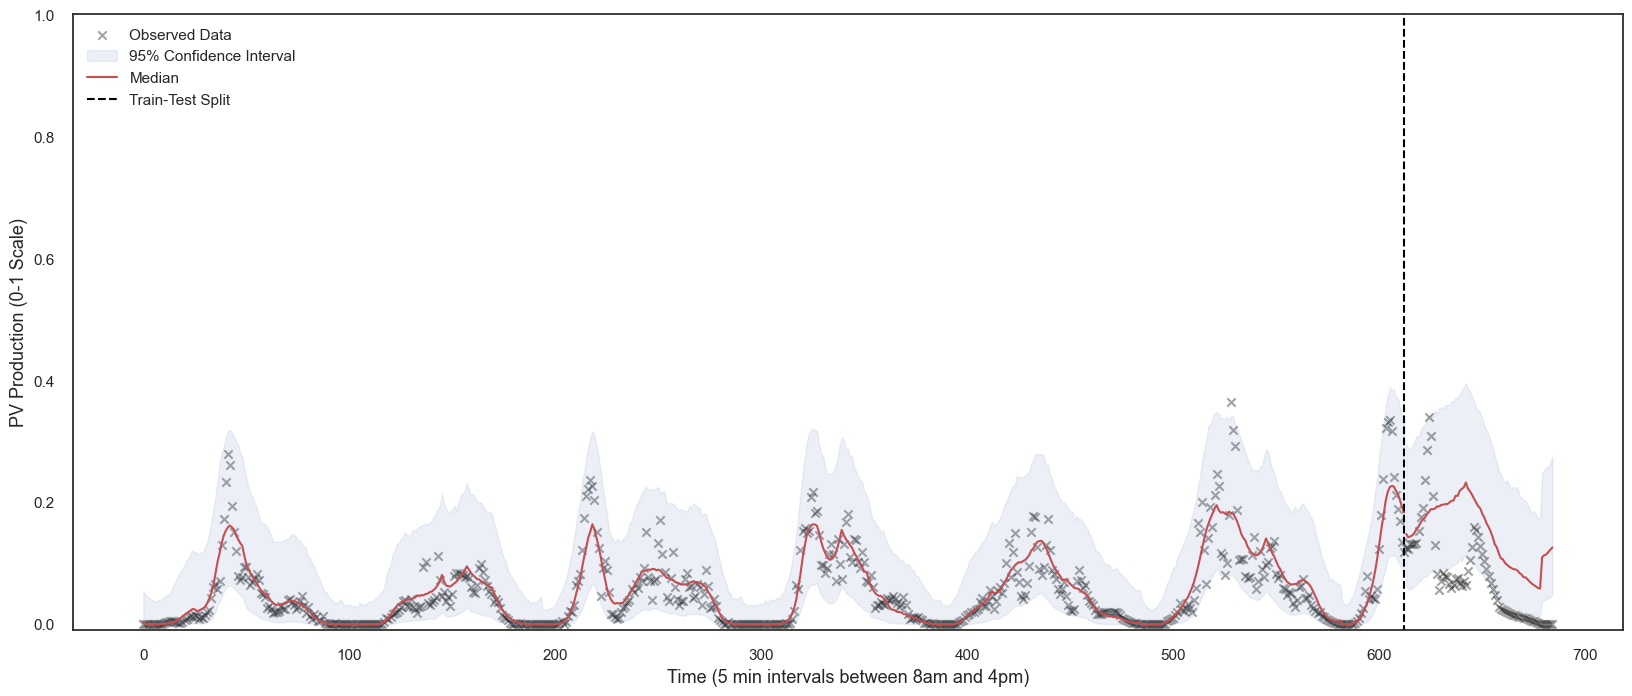

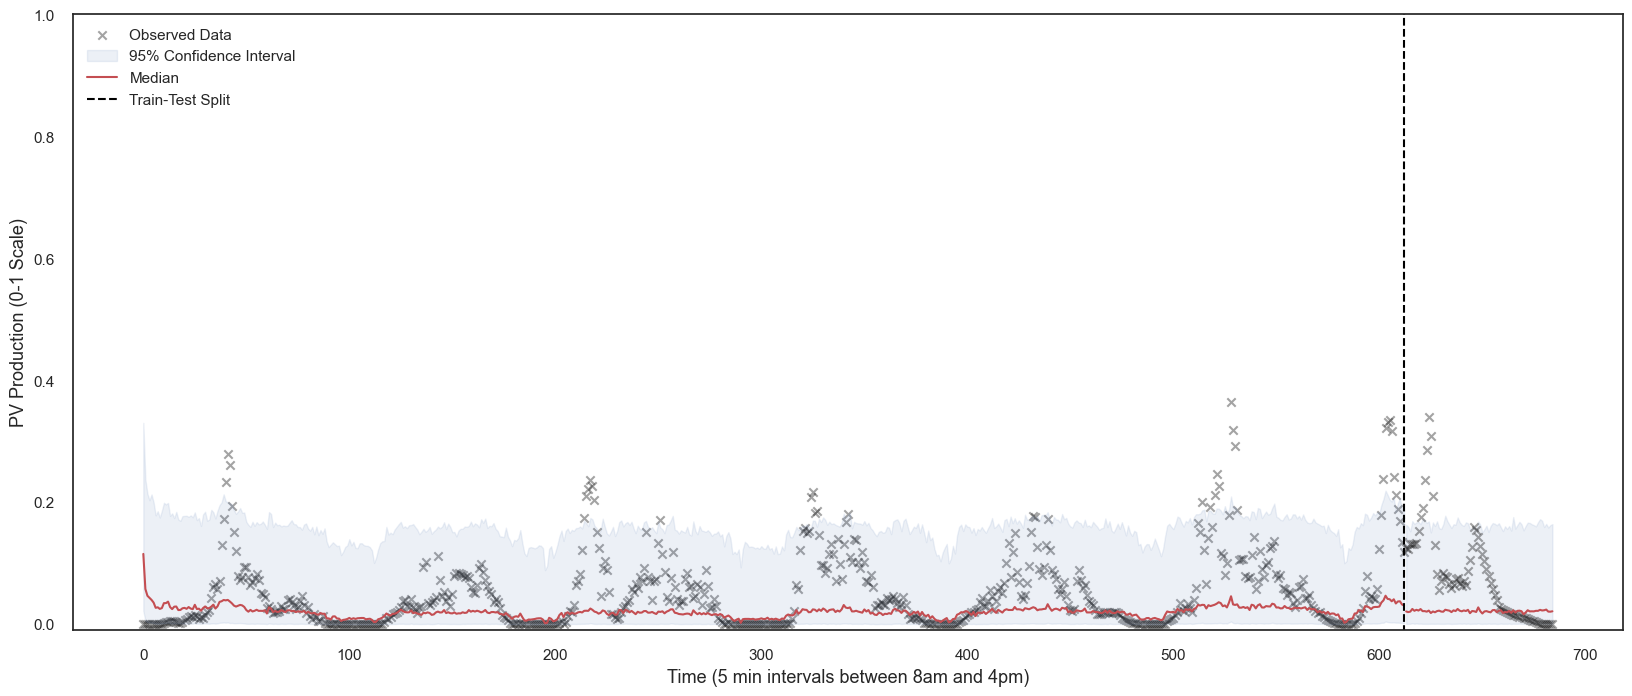

Iter 20/200 - Loss: 3.375
Iter 40/200 - Loss: -0.917
Iter 60/200 - Loss: -2.350
Iter 80/200 - Loss: -2.864
Iter 100/200 - Loss: -3.128
Iter 120/200 - Loss: -3.268
Iter 140/200 - Loss: -3.331
Iter 160/200 - Loss: -3.404
Iter 180/200 - Loss: -3.389
Iter 200/200 - Loss: -3.400
Iter 20/200 - Loss: 11.941
Iter 40/200 - Loss: -0.233
Iter 60/200 - Loss: -1.592
Iter 80/200 - Loss: -2.082
Iter 100/200 - Loss: -2.299
Iter 120/200 - Loss: -2.452
Iter 140/200 - Loss: -2.570
Iter 160/200 - Loss: -2.663
Iter 180/200 - Loss: -2.739
Iter 200/200 - Loss: -2.802


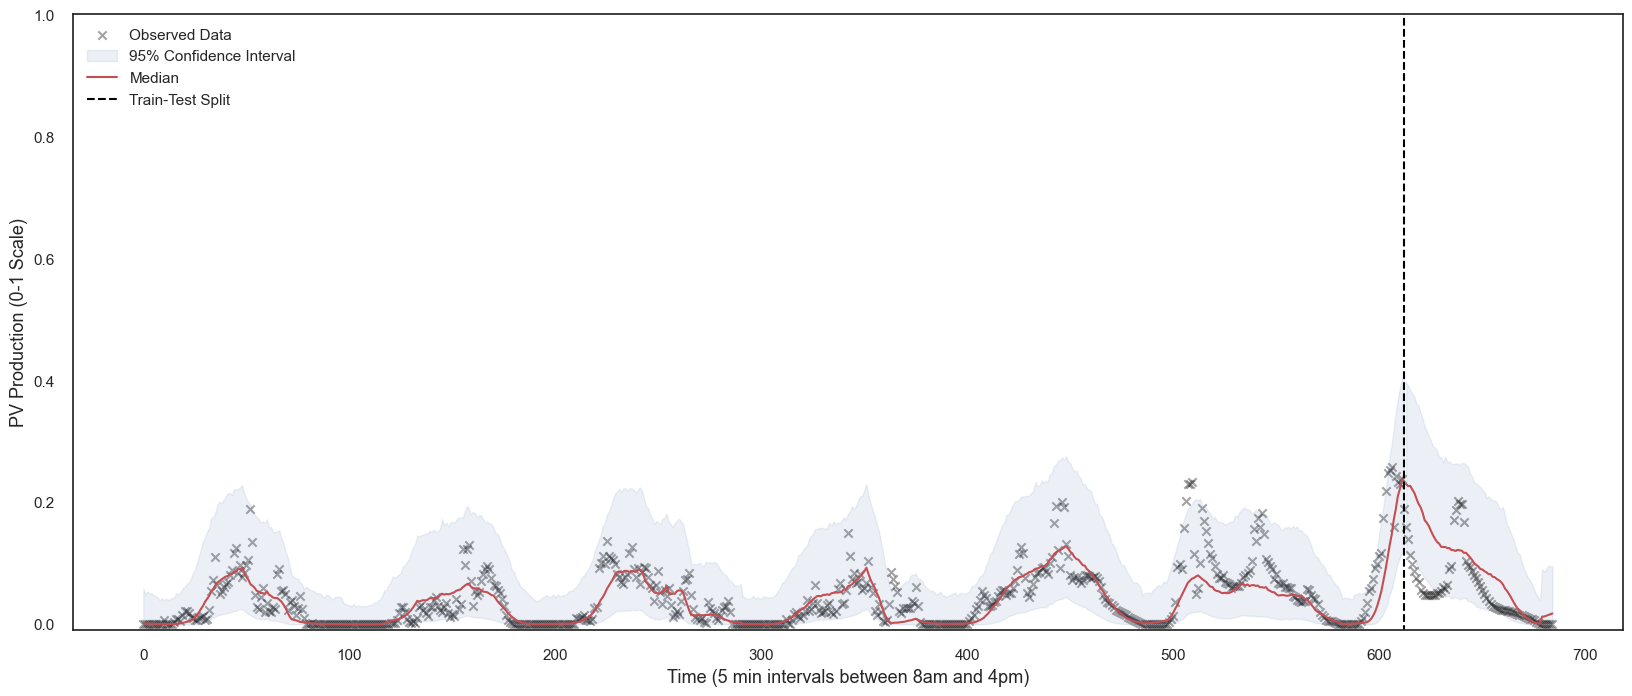

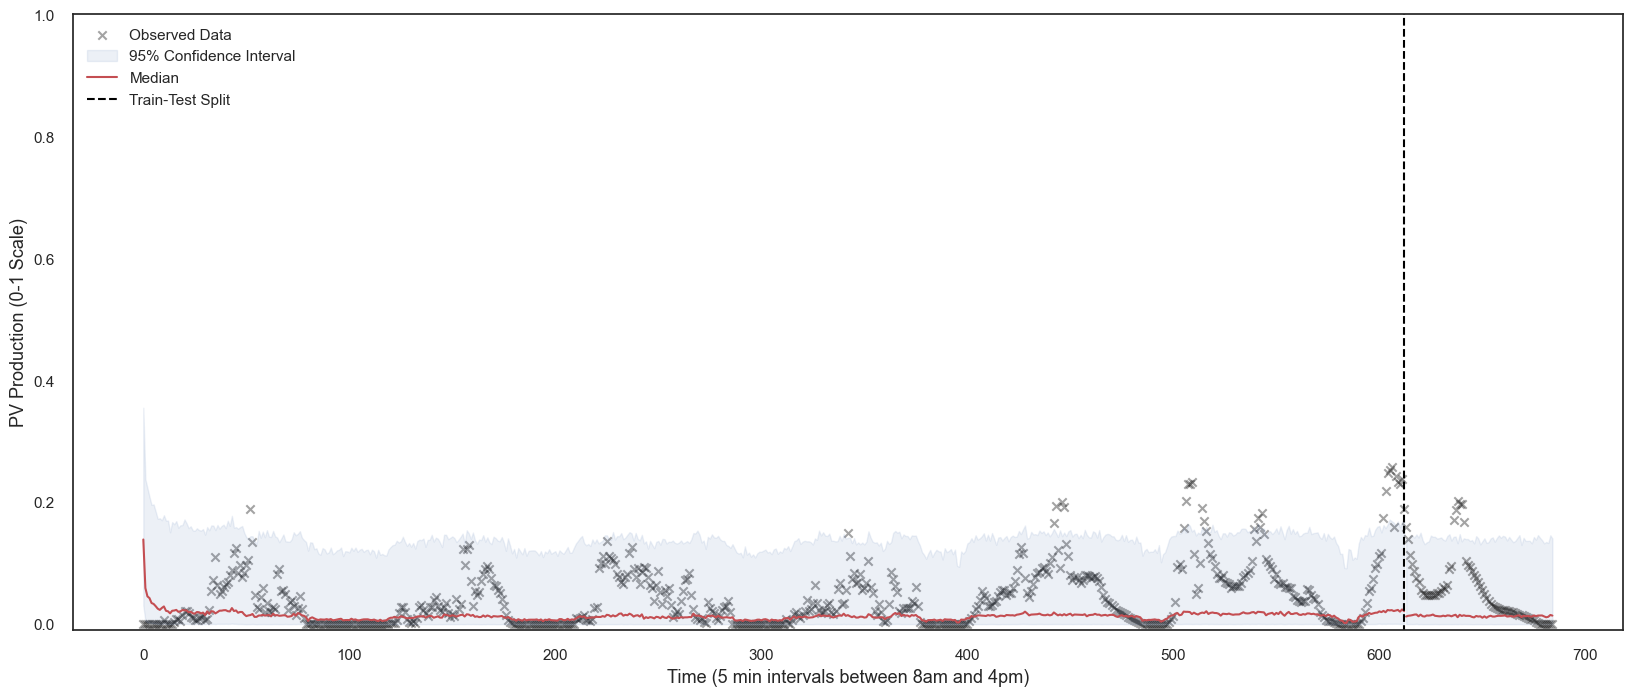

Iter 20/200 - Loss: 3.363
Iter 40/200 - Loss: -1.333
Iter 60/200 - Loss: -2.774
Iter 80/200 - Loss: -3.337
Iter 100/200 - Loss: -3.620
Iter 120/200 - Loss: -3.780
Iter 140/200 - Loss: -3.862
Iter 160/200 - Loss: -3.929
Iter 180/200 - Loss: -3.966
Iter 200/200 - Loss: -3.990
Iter 20/200 - Loss: 12.999
Iter 40/200 - Loss: -0.169
Iter 60/200 - Loss: -1.847
Iter 80/200 - Loss: -2.443
Iter 100/200 - Loss: -2.692
Iter 120/200 - Loss: -2.849
Iter 140/200 - Loss: -2.968
Iter 160/200 - Loss: -3.063
Iter 180/200 - Loss: -3.142
Iter 200/200 - Loss: -3.209


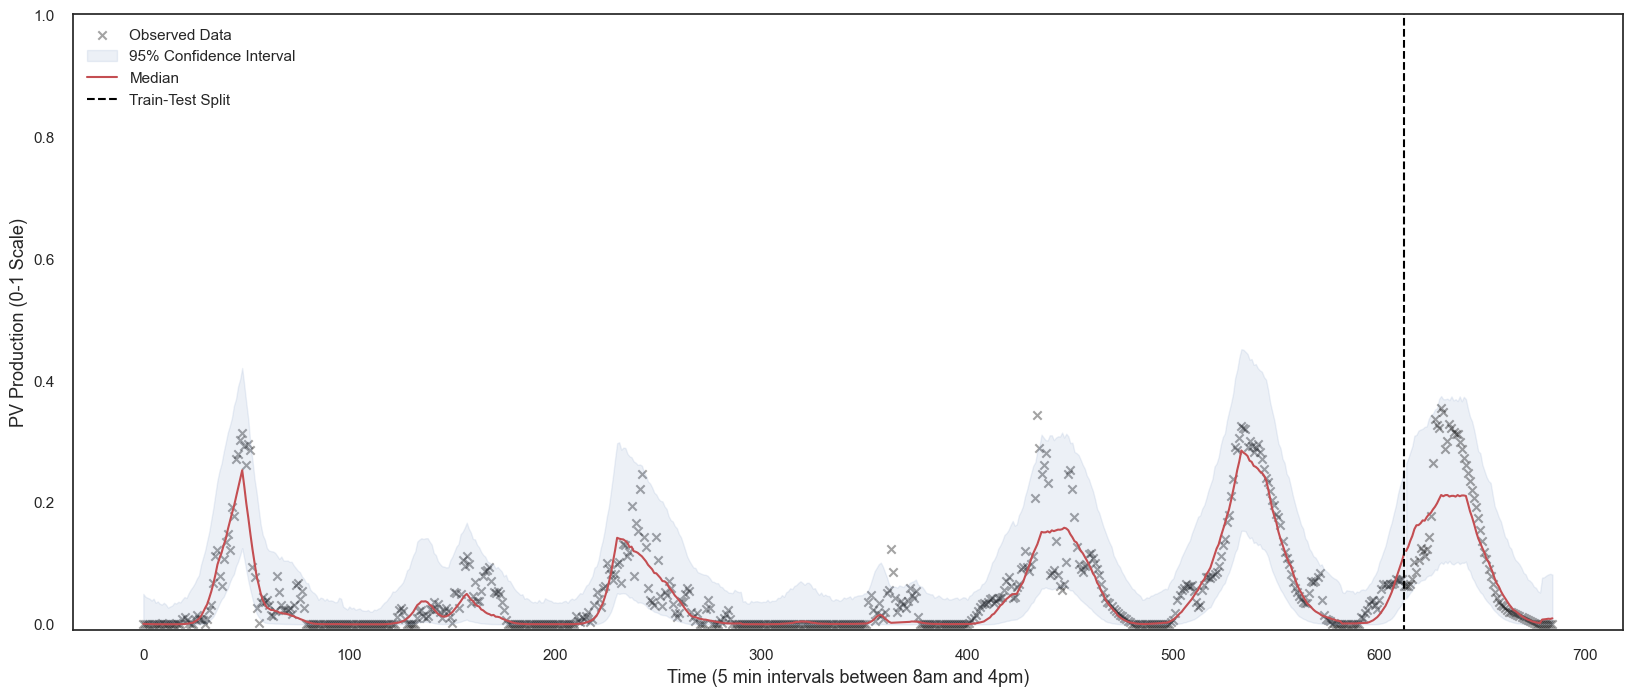

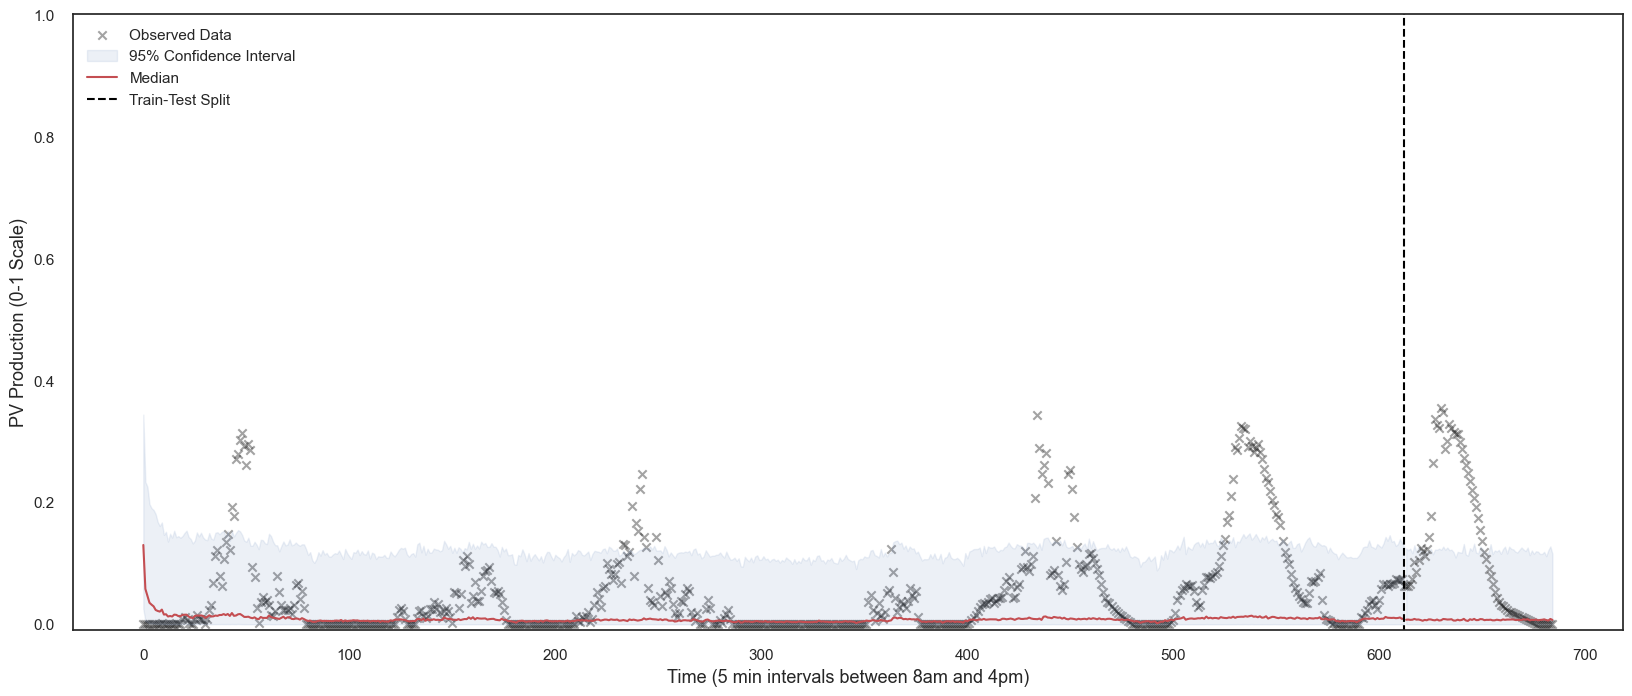

Iter 20/200 - Loss: 2.893
Iter 40/200 - Loss: -1.133
Iter 60/200 - Loss: -2.411
Iter 80/200 - Loss: -2.898
Iter 100/200 - Loss: -3.135
Iter 120/200 - Loss: -3.284
Iter 140/200 - Loss: -3.304
Iter 160/200 - Loss: -3.418
Iter 180/200 - Loss: -3.404
Iter 200/200 - Loss: -3.504
Iter 20/200 - Loss: 12.534
Iter 40/200 - Loss: -0.018
Iter 60/200 - Loss: -1.410
Iter 80/200 - Loss: -1.946
Iter 100/200 - Loss: -2.180
Iter 120/200 - Loss: -2.336
Iter 140/200 - Loss: -2.454
Iter 160/200 - Loss: -2.548
Iter 180/200 - Loss: -2.626
Iter 200/200 - Loss: -2.693


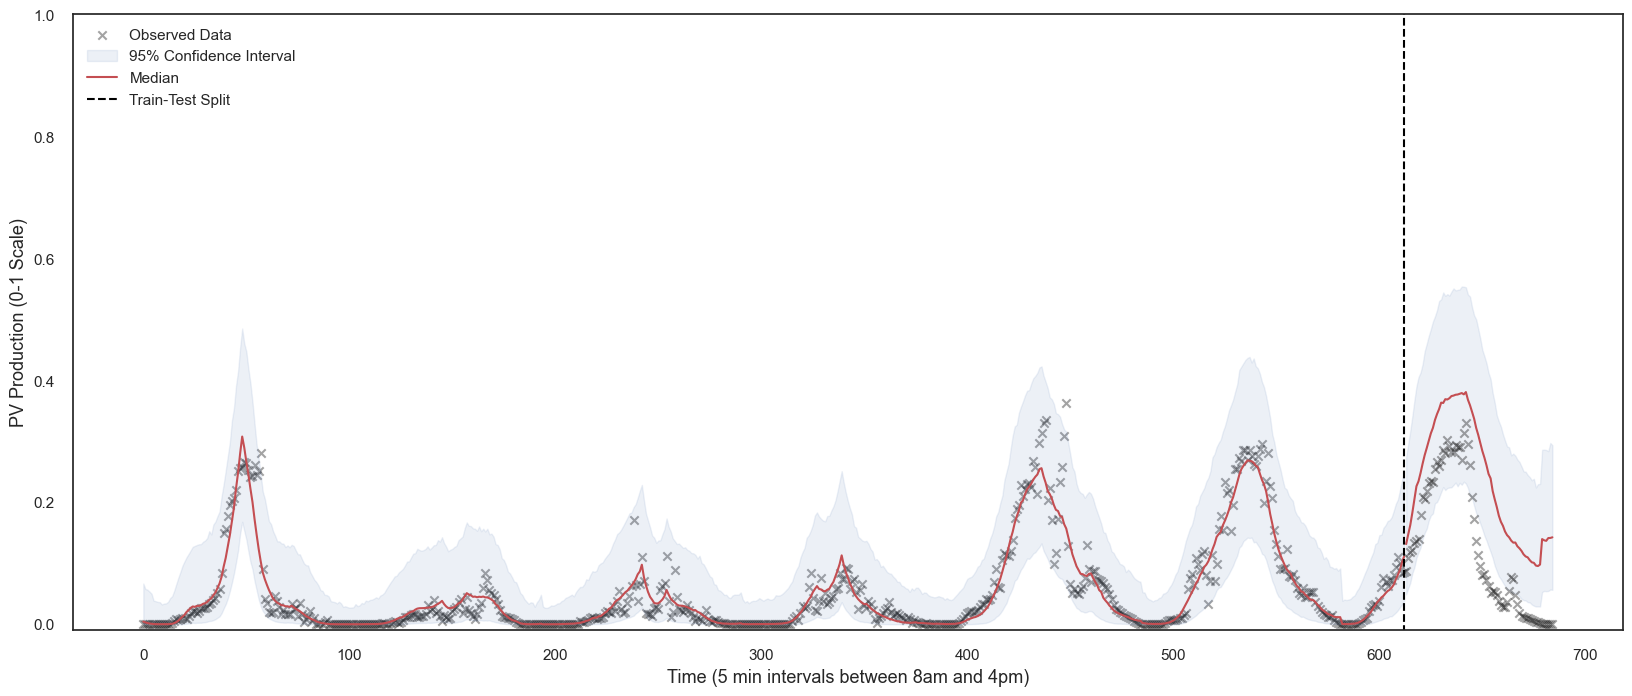

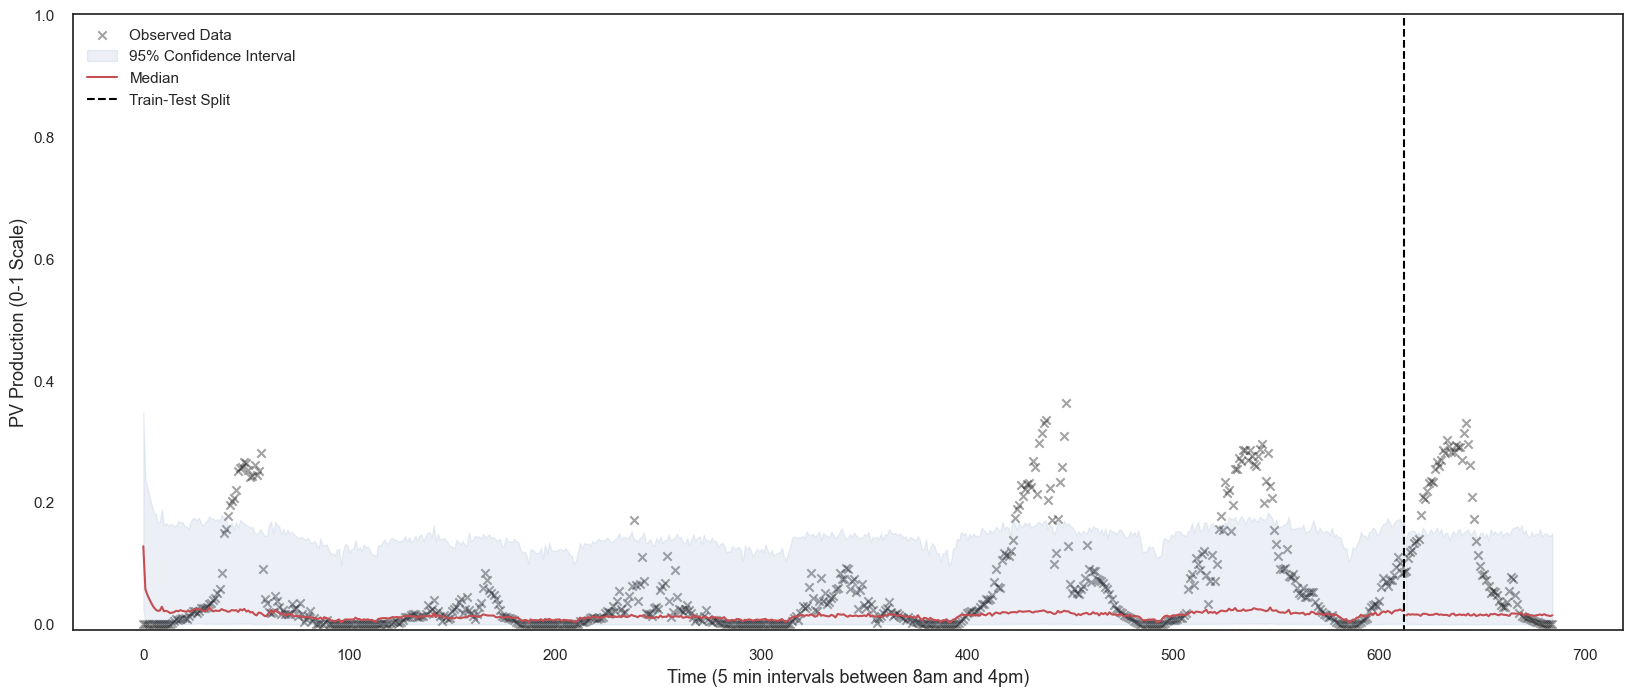

Iter 20/200 - Loss: 3.372
Iter 40/200 - Loss: -0.809
Iter 60/200 - Loss: -1.939
Iter 80/200 - Loss: -2.410
Iter 100/200 - Loss: -2.595
Iter 120/200 - Loss: -2.711
Iter 140/200 - Loss: -2.806
Iter 160/200 - Loss: -2.852
Iter 180/200 - Loss: -2.761
Iter 200/200 - Loss: -2.882
Iter 20/200 - Loss: 12.321
Iter 40/200 - Loss: 0.190
Iter 60/200 - Loss: -1.027
Iter 80/200 - Loss: -1.461
Iter 100/200 - Loss: -1.701
Iter 120/200 - Loss: -1.874
Iter 140/200 - Loss: -2.005
Iter 160/200 - Loss: -2.104
Iter 180/200 - Loss: -2.181
Iter 200/200 - Loss: -2.242


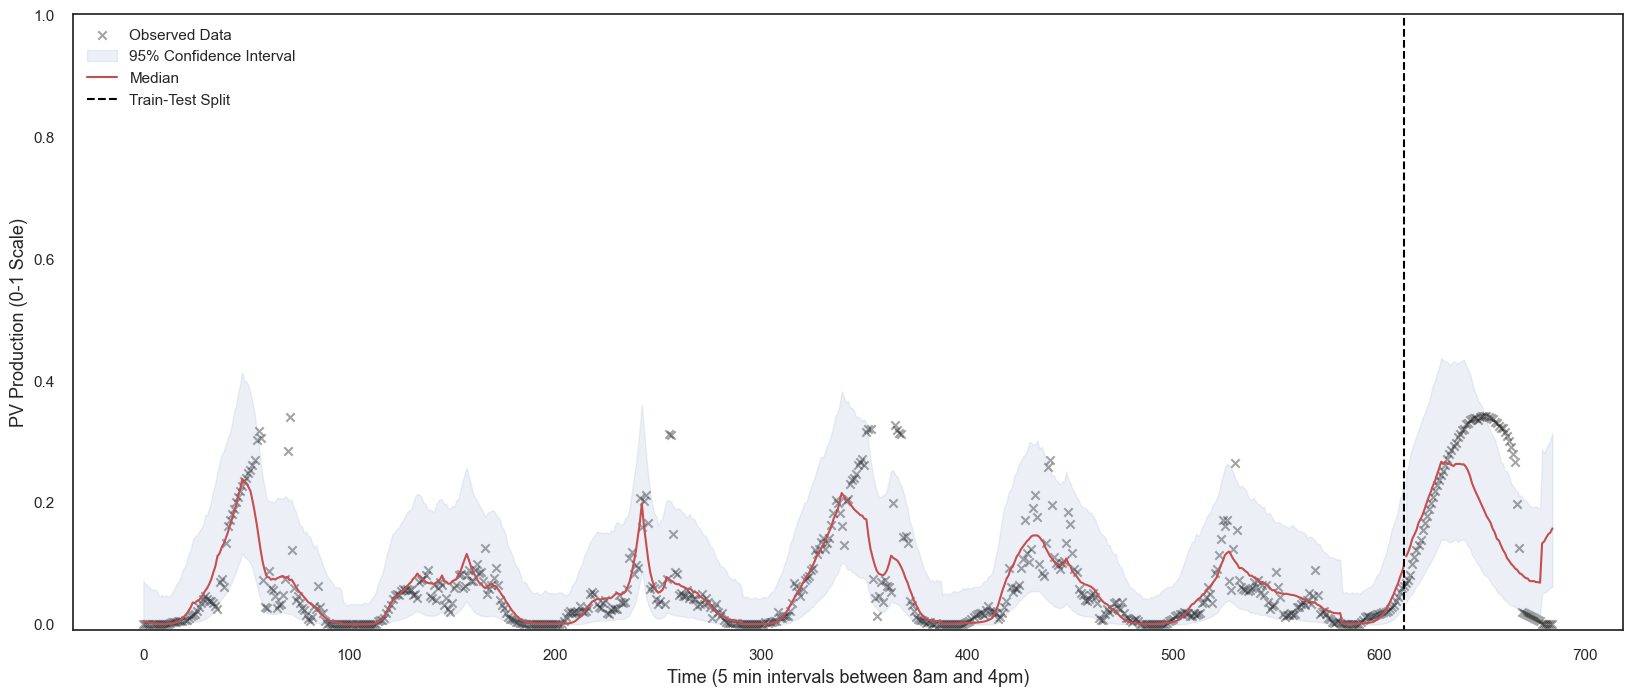

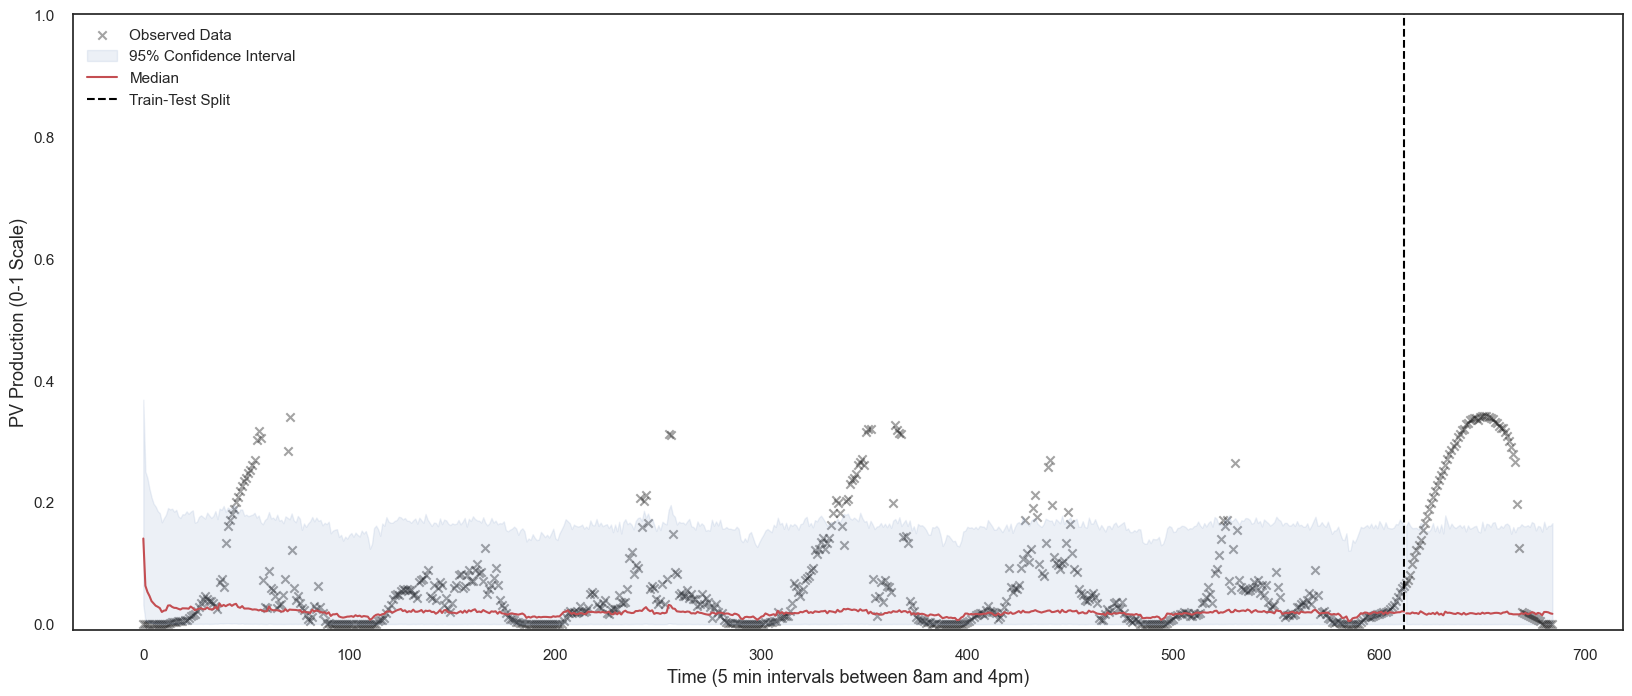

Iter 20/200 - Loss: 3.236
Iter 40/200 - Loss: -0.428
Iter 60/200 - Loss: -1.643
Iter 80/200 - Loss: -2.144
Iter 100/200 - Loss: -2.423
Iter 120/200 - Loss: -2.592
Iter 140/200 - Loss: -2.654
Iter 160/200 - Loss: -2.724
Iter 180/200 - Loss: -2.754
Iter 200/200 - Loss: -2.823
Iter 20/200 - Loss: 12.413
Iter 40/200 - Loss: 0.755
Iter 60/200 - Loss: -0.583
Iter 80/200 - Loss: -1.091
Iter 100/200 - Loss: -1.353
Iter 120/200 - Loss: -1.554
Iter 140/200 - Loss: -1.724
Iter 160/200 - Loss: -1.885
Iter 180/200 - Loss: -2.058
Iter 200/200 - Loss: -2.219


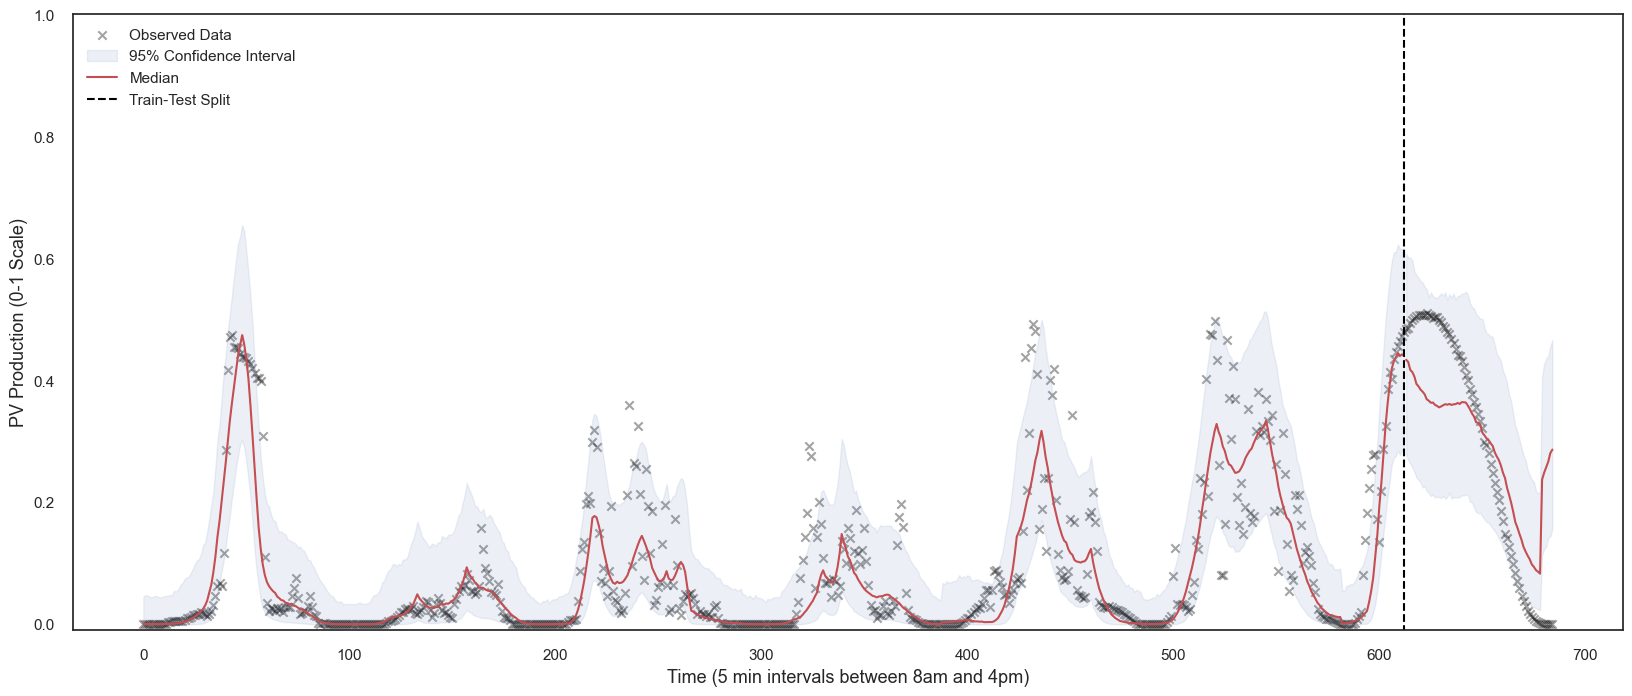

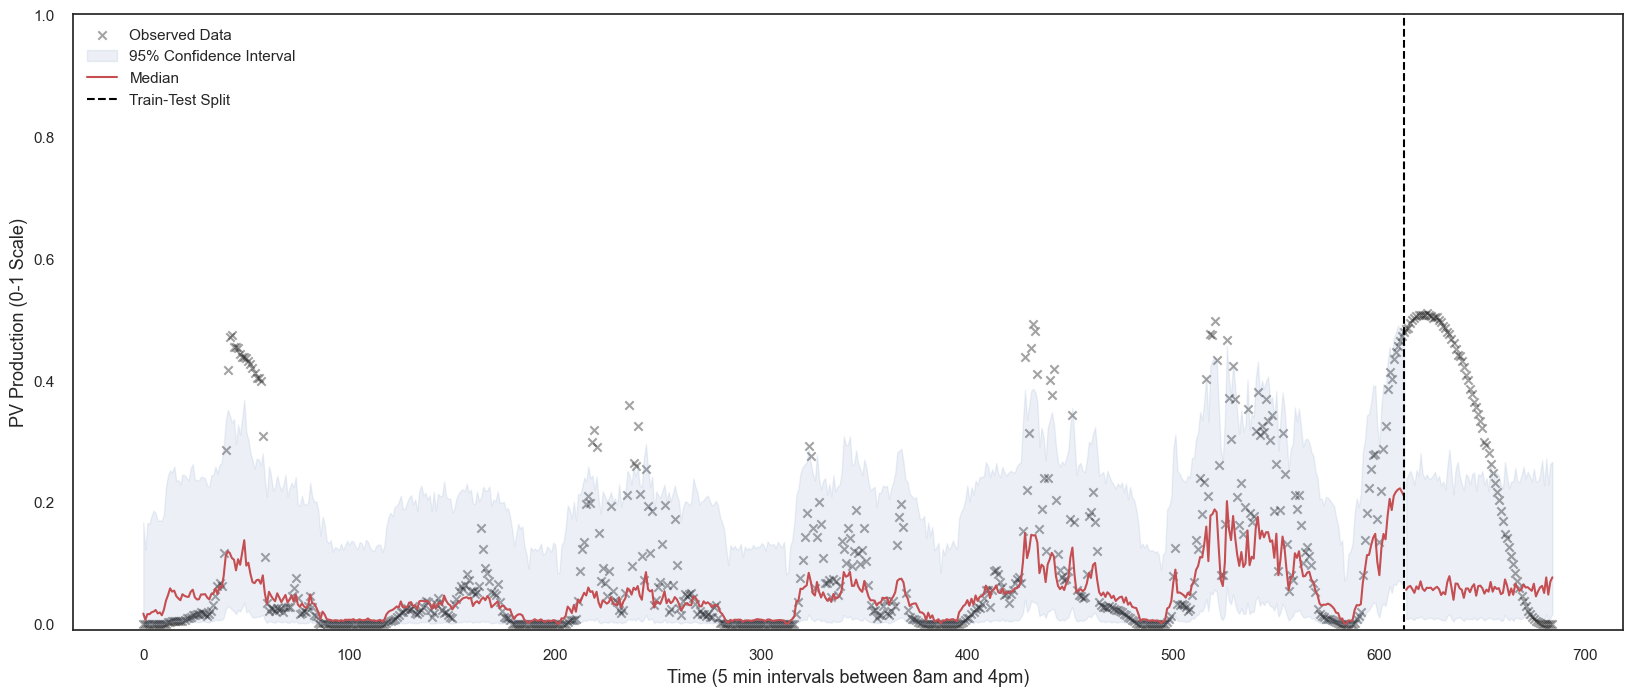

Iter 20/200 - Loss: 3.058
Iter 40/200 - Loss: -0.845
Iter 60/200 - Loss: -1.984
Iter 80/200 - Loss: -2.472
Iter 100/200 - Loss: -2.736
Iter 120/200 - Loss: -2.886
Iter 140/200 - Loss: -2.953
Iter 160/200 - Loss: -3.044
Iter 180/200 - Loss: -3.044
Iter 200/200 - Loss: -3.088
Iter 20/200 - Loss: 12.450
Iter 40/200 - Loss: 0.334
Iter 60/200 - Loss: -1.092
Iter 80/200 - Loss: -1.602
Iter 100/200 - Loss: -1.841
Iter 120/200 - Loss: -2.008
Iter 140/200 - Loss: -2.139
Iter 160/200 - Loss: -2.247
Iter 180/200 - Loss: -2.340
Iter 200/200 - Loss: -2.427


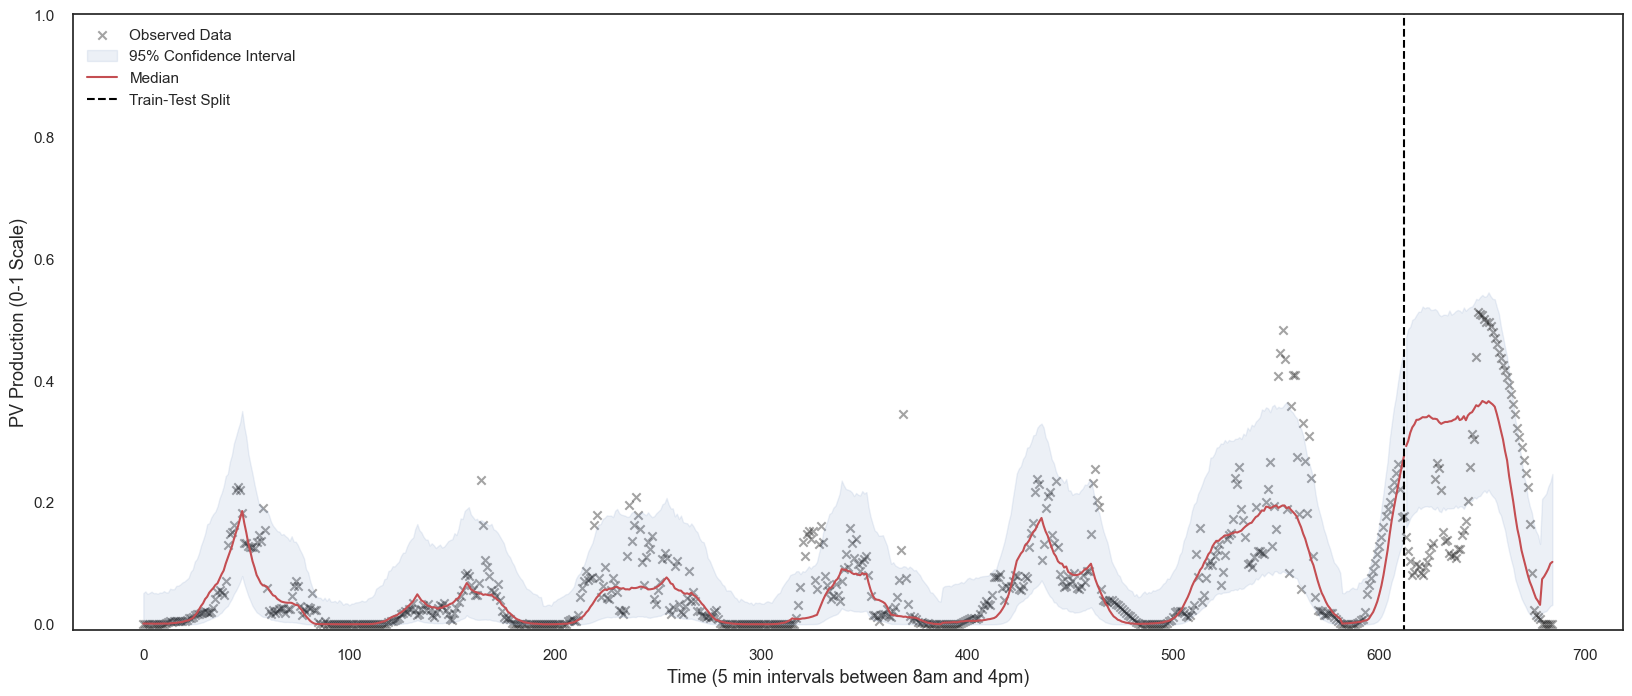

KeyboardInterrupt: 

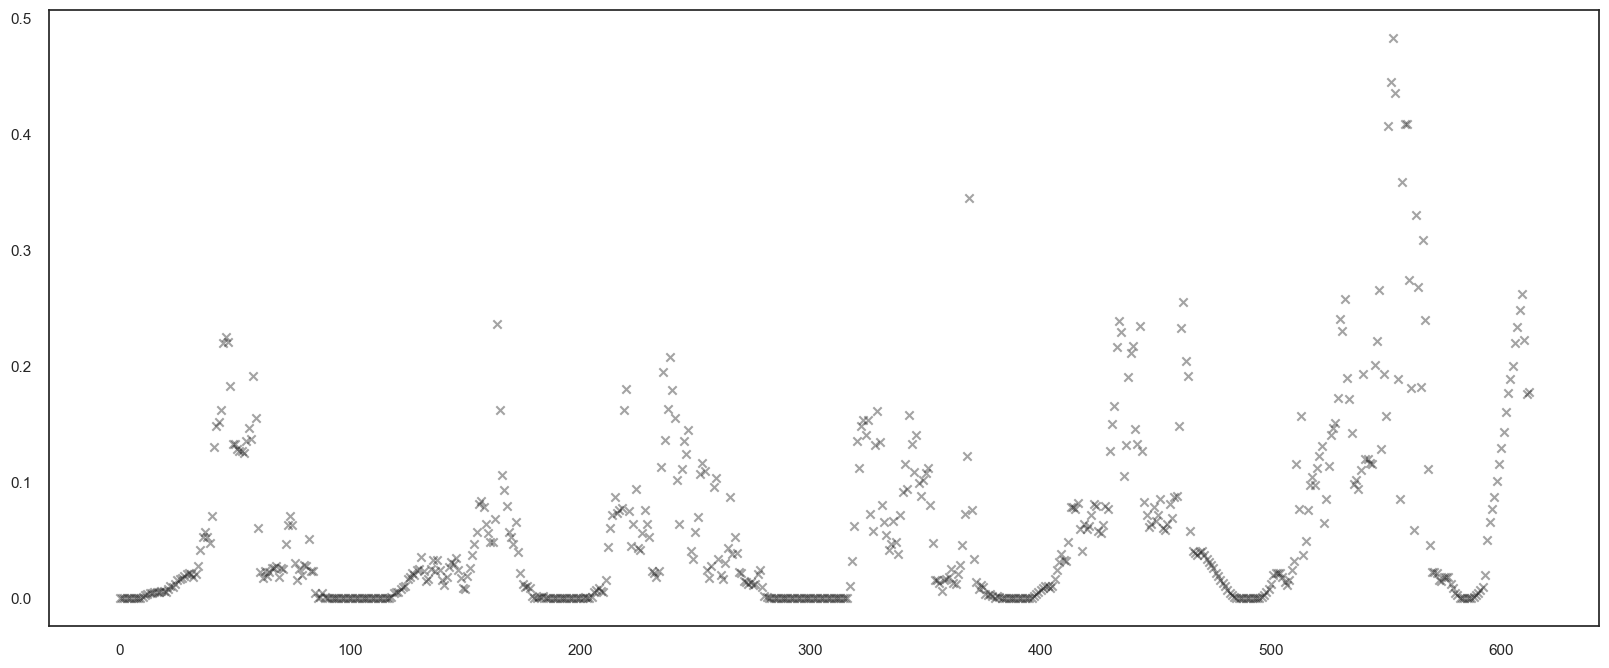

In [5]:
from kernels import get_mean_covar_weather
from models import ApproximateGPBaseModel
from likelihoods import BetaLikelihood_MeanParametrization
from pv_plot import plot_gp

for X_tr, Y_tr, X_te, Y_te, T_tr, T_te in loader:

    for i in range(loader.n_systems):
        x_tr, y_tr, x_te, y_te = loader.train_test_split_individual(i)

        gp_config['num_inducing_points'] = x_tr.shape[0]
        mean, covar1 = get_mean_covar_weather(num_latents=1, d=x_tr.shape[-1])
        _, covar2 = get_mean_covar_weather(
                        num_latents=1, 
                        d=x_tr.shape[-1], 
                        weather_kernel='matern',
                        combine='sum')

        model1 = ApproximateGPBaseModel(
            X=x_tr,
            y=y_tr,
            mean_module=mean,
            covar_module=covar1,
            likelihood = BetaLikelihood_MeanParametrization(scale=30),
            config=gp_config,
        )
        model2 = ApproximateGPBaseModel(
            X=x_tr,
            y=y_tr,
            mean_module=mean,
            covar_module=covar2,
            likelihood = BetaLikelihood_MeanParametrization(scale=20),
            config=gp_config,
        )
        model1.fit(n_iter=200, lr=0.2, verbose=True)
        model2.fit(n_iter=200, lr=0.2, verbose=True)

        plot_gp(model1, x_tr, x_te, y_tr, y_te, pred_type='median')
        plot_gp(model2, x_tr, x_te, y_tr, y_te, pred_type='median')
       
        
    # updated slicing
    break


Text(0, 0.5, '$f(x)$')

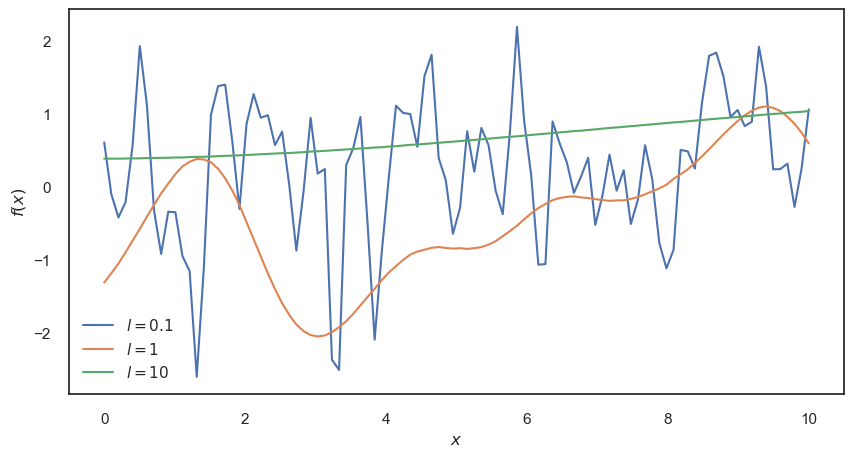

In [26]:
dist = model(x_train)
sample
